In [1]:
import os
import sys
import warnings
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

In [2]:
NB_DIR = os.path.abspath(os.getcwd())
ROOT_DIR = os.path.abspath(os.path.join(NB_DIR, ".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [3]:
from core.model import TumorNet34Bayes
from core.utils import set_seed

In [4]:
ROOT_RESULTS = r"..\results"
CKPT_DIR     = os.path.join(ROOT_RESULTS, "checkpoints")
VIZ_DIR      = os.path.join(ROOT_RESULTS, "visualizations")
for d in [ROOT_RESULTS, CKPT_DIR, VIZ_DIR]:
    os.makedirs(d, exist_ok=True)

In [5]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Device:", device)

Device: cuda


In [6]:
# Load test data
X_test = np.load(os.path.join(ROOT_DIR, "data", "processed", "X_test.npy"))
y_test = np.load(os.path.join(ROOT_DIR, "data", "processed", "y_test.npy"))
X_test_t = torch.tensor(X_test, dtype=torch.float32).permute(0,3,1,2).to(device)

In [7]:
weights_path = os.path.join(CKPT_DIR, "model_weights_best.pth")  
assert os.path.exists(weights_path), f"Checkpoint not found: {weights_path}"
model = TumorNet34Bayes(dropout_p=0.4).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()
print("✅ Loaded:", weights_path)

✅ Loaded: ..\results\checkpoints\model_weights_best.pth


In [8]:
def grad_cam(model, image, target_layer="layer4"):
    """
    image: (3,224,224) on device, float
    returns: (cam[224,224], prob, pred_int)
    """
    image = image.unsqueeze(0)
    grads, activs = [], []

    def fhook(module, inp, out): activs.append(out.detach())
    def bhook(module, gin, gout): grads.append(gout[0].detach())

    layer = dict([*model.named_modules()])[target_layer]
    fh = layer.register_forward_hook(fhook)
    bh = layer.register_backward_hook(bhook)

    model.zero_grad(set_to_none=True)
    logits, probs, conf = model(image)     
    prob = torch.sigmoid(logits).squeeze()
    pred = (prob > 0.5).float()
    prob.backward()  

    g, a = grads[0], activs[0]               
    weights = g.mean(dim=(2,3), keepdim=True)
    cam = (weights * a).sum(dim=1).squeeze()
    cam = torch.relu(cam)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam.detach().cpu().numpy(), (224,224))

    fh.remove(); bh.remove()
    return cam, float(prob.item()), int(pred.item())

In [9]:
@torch.no_grad()
def mc_dropout_pred(model, image, T=20):
    model.eval()  
    probs = []
    for _ in range(T):
        def enable_dropout(m):
            if type(m) == torch.nn.Dropout:
                m.train()
        model.apply(enable_dropout)

        logits, *_ = model(image.unsqueeze(0))
        p = torch.sigmoid(logits).item()
        probs.append(p)
    probs = np.array(probs)
    return float(probs.mean()), float(probs.std())

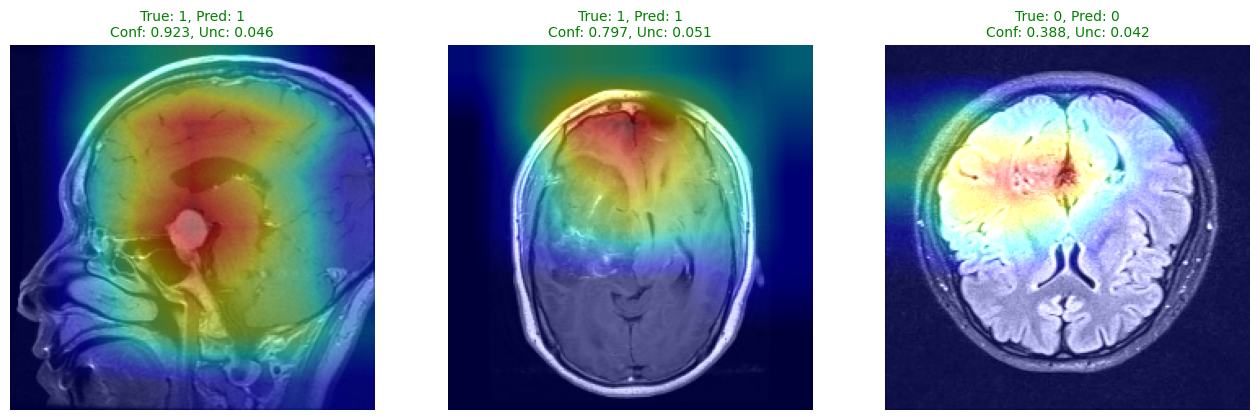

In [10]:
N_SHOW = min(3, len(X_test))
plt.figure(figsize=(16, 5))

for i in range(N_SHOW):
    img_t = X_test_t[i]
    cam, conf, pred = grad_cam(model, img_t, target_layer="layer4")
    mean_p, std_p = mc_dropout_pred(model, img_t, T=20)

    base_img = (X_test[i] * 255).astype(np.uint8)
    heatmap = (plt.cm.jet(cam)[:, :, :3] * 255).astype(np.uint8)
    overlay = cv2.addWeighted(base_img, 1.0, heatmap, 0.45, 0)

    plt.subplot(1, N_SHOW, i + 1)
    plt.imshow(overlay)
    true_label = int(y_test[i])
    title_color = "green" if pred == true_label else "red"
    plt.title(
        f"True: {true_label}, Pred: {pred}\nConf: {conf:.3f}, Unc: {std_p:.3f}",
        color=title_color,
        fontsize=10
    )
    plt.axis("off")

In [11]:
out_path = os.path.join(VIZ_DIR, "doctor_demo.png")
plt.tight_layout()
plt.savefig(out_path, dpi=160)
plt.show()
print(f"🖼 Saved overlay preview → {out_path}")

<Figure size 640x480 with 0 Axes>

🖼 Saved overlay preview → ..\results\visualizations\doctor_demo.png


In [12]:
all_mean_probs, all_preds, all_labels = [], [], []
pbar = tqdm(range(len(X_test_t)), desc="Testing (MC Dropout)", leave=False)
for i in pbar:
    img_t = X_test_t[i]
    mean_p, std_p = mc_dropout_pred(model, img_t, T=20)
    all_mean_probs.append(mean_p)
    all_preds.append(int(mean_p > 0.5))
    all_labels.append(int(y_test[i]))

acc = accuracy_score(all_labels, all_preds)
try:
    auc = roc_auc_score(all_labels, all_mean_probs)
except ValueError:
    auc = float("nan")
f1  = f1_score(all_labels, all_preds)

print("\n==================== FINAL RESULTS ====================")
print(f"🩺 Test Accuracy : {acc:.4f}")
print(f"📈 Test AUC-ROC : {auc:.4f}")
print(f"🔁 Test F1-Score: {f1:.4f}")
print("🔮 Uncertainty  : MC-Dropout std shown per example")
print("🖼 Visuals      : Grad-CAM overlays saved in results/visualizations")
print("=======================================================\n")

Testing (MC Dropout):   0%|          | 0/600 [00:00<?, ?it/s]


==================== FINAL RESULTS ====================
🩺 Test Accuracy : 0.8267
📈 Test AUC-ROC : 0.9910
🔁 Test F1-Score: 0.8514
🔮 Uncertainty  : MC-Dropout std shown per example
🖼 Visuals      : Grad-CAM overlays saved in results/visualizations



In [13]:
summary = {
    "test_size": int(len(all_labels)),
    "accuracy": float(acc),
    "auc": float(auc) if not np.isnan(auc) else None,
    "f1": float(f1)
}
with open(os.path.join(ROOT_RESULTS, "inference_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)
print(f"✅ Saved summary → {os.path.join(ROOT_RESULTS, 'inference_summary.json')}")

✅ Saved summary → ..\results\inference_summary.json
